In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import catboost
import lightgbm
import xgboost

In [24]:
data = pd.read_csv("../data/processed/data.csv", parse_dates=["date_forecast", "date_calc"])

# Modeling Notebook

Each model returns is trained on a subset of the data. The models are then combined into a voting classifier. The voting classifier is then used to predict the test data.

## 1. General Model

### Feature Engineering and Selection

In [25]:
data_general = data.copy()

### Model Setup

In [ ]:
# CatBoost

### Model Result

## 2. Summer Model

### Feature Engineering and Selection

In [27]:
data_summer = data.copy()

### Model Setup

### Model Result

## 3. Cloud Height Model

### Feature Engineering and Selection

In [30]:
data_cloud = data.copy()

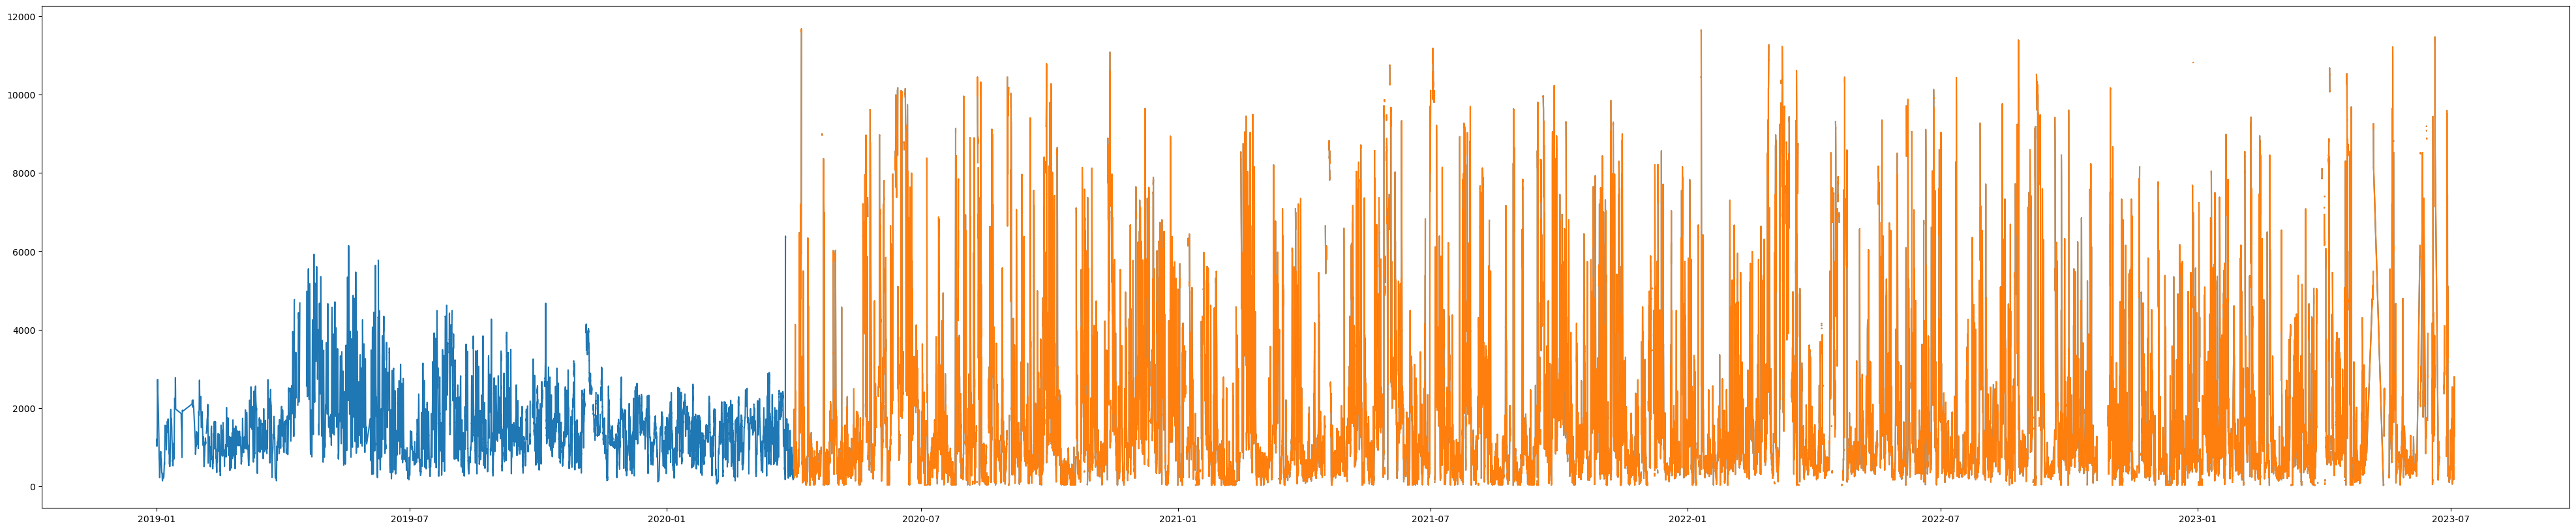

In [35]:
# Observe the outlier data

plt.figure(figsize=(50, 10))
plt.plot(data_cloud["date_forecast"], data_cloud["cloud_base_agl:m"])
plt.plot(
    data_cloud[data_cloud["date_forecast"] >= "2020-04-01"]["date_forecast"],
    data_cloud[data_cloud["date_forecast"] >= "2020-04-01"]["cloud_base_agl:m"],
)

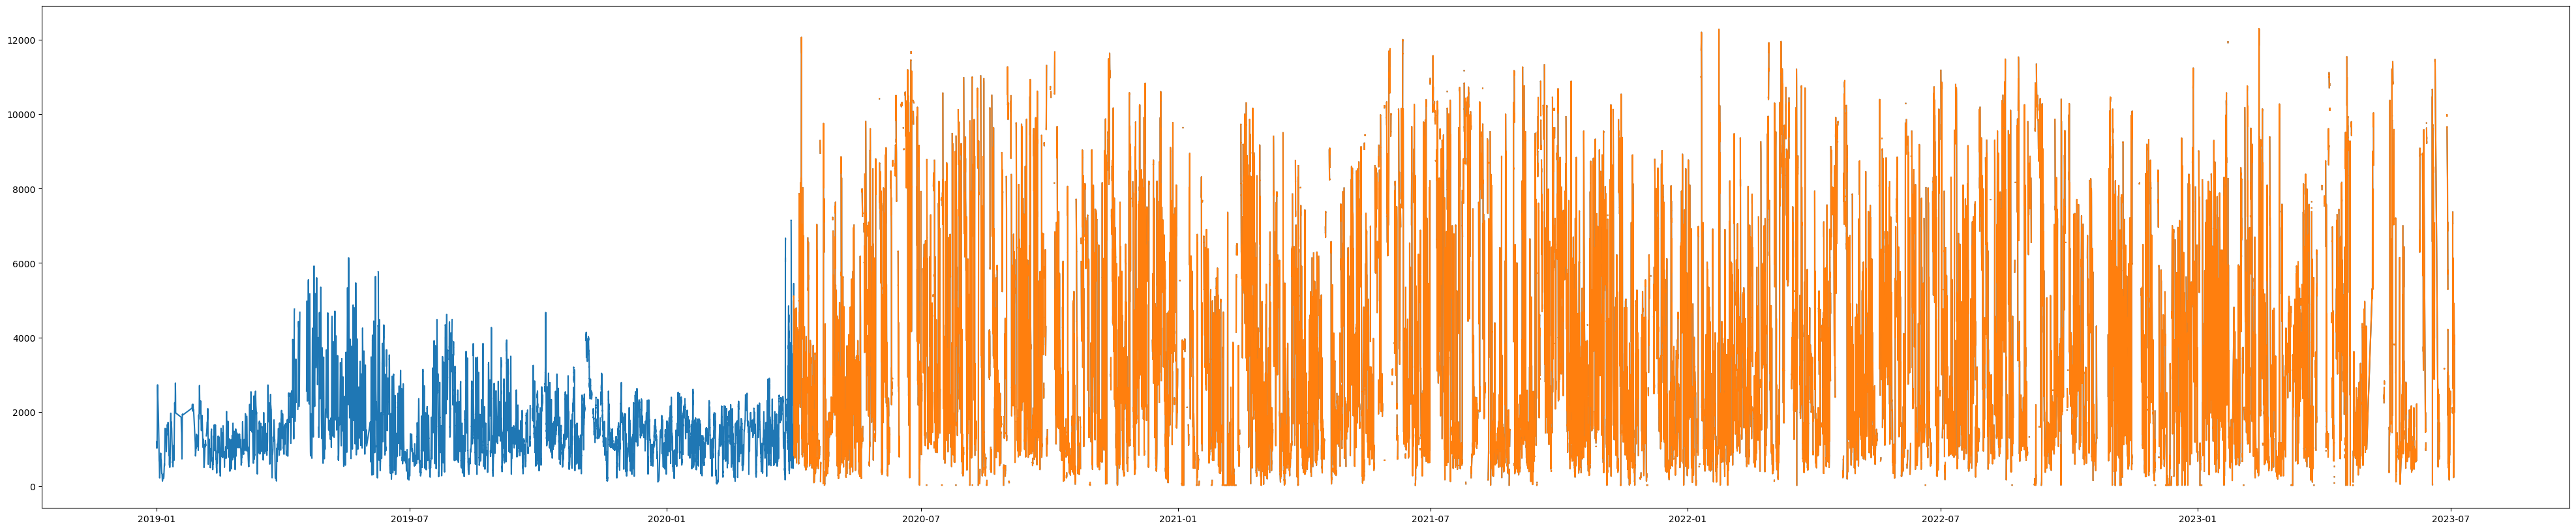

In [39]:
# Observe the outlier data

plt.figure(figsize=(50, 10))
plt.plot(data_cloud["date_forecast"], data_cloud["ceiling_height_agl:m"])
plt.plot(
    data_cloud[data_cloud["date_forecast"] >= "2020-04-01"]["date_forecast"],
    data_cloud[data_cloud["date_forecast"] >= "2020-04-01"]["ceiling_height_agl:m"],
)

### Model Setup

### Model Result

## 4. Precipitation Model

### Feature Engineering and Selection

In [29]:
data_precip = data.copy()

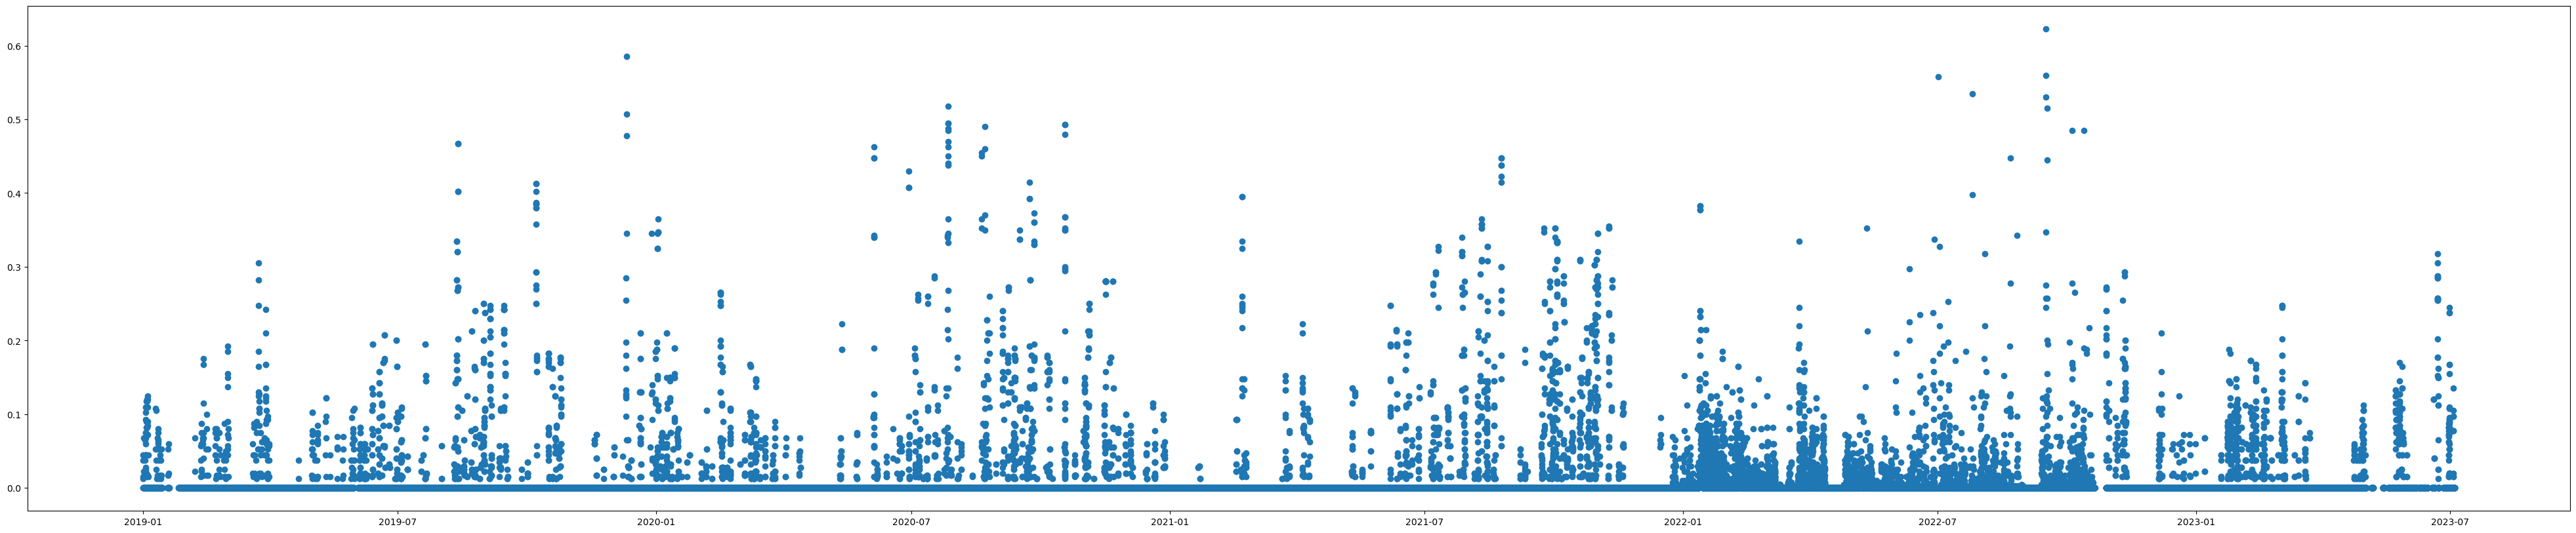

In [44]:
# Observe the outlier data

plt.figure(figsize=(50, 10))
plt.scatter(data_precip["date_forecast"], data_cloud["precip_5min:mm"])

### Model Setup

### Model Result

## Ensemble Model